# GOOGLE TRENDS AND THE UNEMPLOYMENT RATE

## Jim Jacisin - Flatiron School

***

## Motivation

*Macroeconomic Metrics:*
- Global: A way to analyze the way the world turns through the way it trades and interacts with its largest members 
- National: Analyzing the economic metrics of a distinct sovereignty to build a picture of fiscal well-being

*The Unemployment Rate:*
- Problem: The U.S. is an enormously complex system
- Solution: Analyze a leading economic indicator and determine if a traditional metric can be improved through big data and machine learning

*Cui Bono?*
- Unemployment Rate and a health economy are highly correlated, predicting a drop in unemployment would help individuals and companies make investing decisions.

*I like this stuff*

***

## Outcome: 

*We can improve our the prediction the unemployment rate by **~25%**, using a SARIMAX model with exogenous job search data*

***

## Project Summary 

*Initial Model*
- Apply an ARIMA time series model to the U.S. unemployment rate to determine to establish a baseline comparison to the other models

*Internet Keyword Model*
- Using Google Trends, obtain information on the frequency of U.S. searches related to the keyword “job”	
- Create an ARIMA time series model using the Google Trend information to determine the predictability of the keyword data

*SARIMAX Exogenous Model*
- Add the job search data as an exogenous variable to the unemployment time series data, a model can be built to improve unemployment forecasting

***

In [152]:
# Import all libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
figsize = [15,6]
from pytrends.request import TrendReq

## Initial Unemployment Model

In [135]:
# Pull and format all U.S. Unemployment Data
df = pd.read_excel('dash_package/BLS_SA_Unemployment.xlsx',header=3)
ts_df = df.transpose()
df_UE = ts_df.iloc[1:]
df_UE.columns = ["SA_Unemployment_Rate"]
date_rng = pd.date_range(start='1/1/1948', end='12/31/2018', freq='MS')
df_UE.index = date_rng
df_UE = df_UE['2000-01-01':]
df_UE.head()

,SA_Unemployment_Rate
2000-01-01,4
2000-02-01,4.1
2000-03-01,4
2000-04-01,3.8
2000-05-01,4


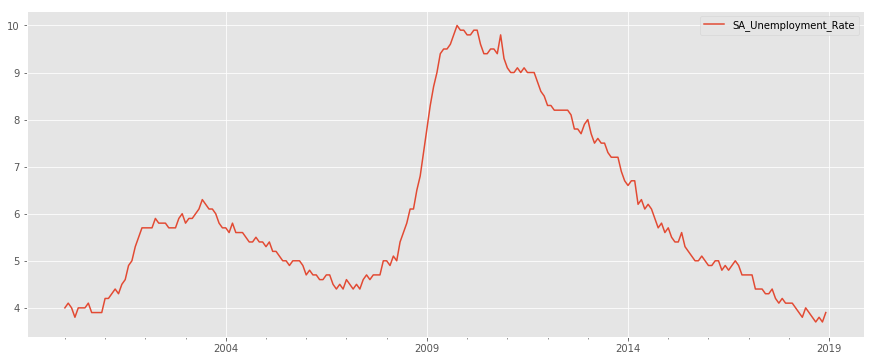

In [136]:
# Initial Data Plot
df_UE.plot(figsize=figsize)

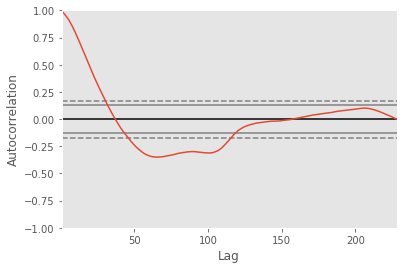

In [137]:
pd.plotting.autocorrelation_plot(df_UE)

- Autocorrelation --> Matching our feature and time. How closely is the information given by time equal to the target feature
- Shows there is a high level of positive correlation between recent periods and negative correlation around 40 - 95 labs, but tends to center around the 0 mean
- Need to perform standardization to smooth correlation

In [138]:
# Create plot to determine stationarity of a timeseries
def test_stationarity(timeseries,window=12):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean - {}'.format(str(window)))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std - {}'.format(str(window)))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

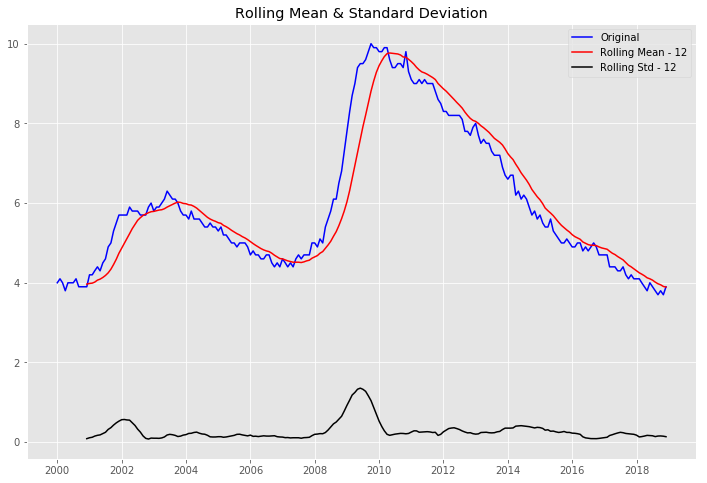

Results of Dickey-Fuller Test:
Test Statistic                  -2.327888
p-value                          0.163131
#Lags Used                       6.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


In [139]:
test_stationarity(df_UE.SA_Unemployment_Rate)

- Test Statistic/p-value vs. Critical Values
    - Statistical test to determine the amount of confidence the information
    - If the Test Statistic is less than a given Critical Value, we can be X% confident the data set is stationary 



- The Test Statistic is much higher than the Critical Values, therefore the data needs to be manipulated to become more stationary

In [140]:
# Apply 12 month Rolling Mean to our dataset
def use_rol_mean(pd_series, window=12):
    rolmean = pd_series.rolling(window).mean()
    data_minus_rolmean = pd_series - rolmean
    # Adding in rolmean creates NaNs for first year
    data_minus_rolmean.dropna(inplace=True)

    # Plot rollingmean
    fig = plt.figure(figsize=(11,7))
    orig = plt.plot(pd_series, color='blue',label='Original')
    plt.plot(data_minus_rolmean, color='red',label='Rolling mean - {}'.format(str(window)))
    plt.legend(loc='best')
    plt.title('Rolling means are subtracted from Original')
    plt.show(block=False)
    return data_minus_rolmean

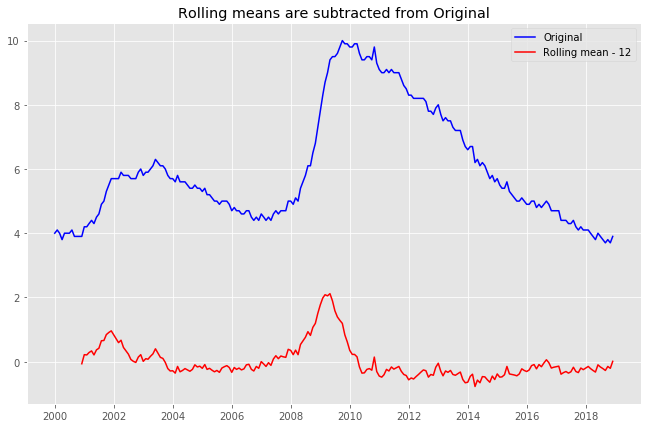

In [141]:
df_UE_rol_mean = use_rol_mean(df_UE,12)

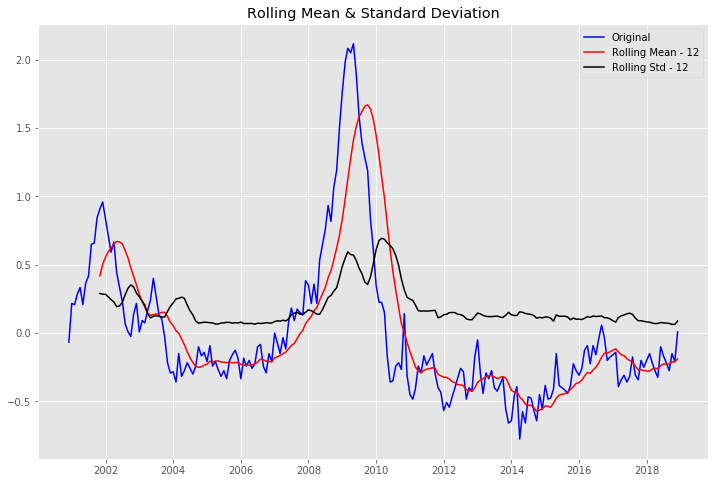

Results of Dickey-Fuller Test:
Test Statistic                  -3.206588
p-value                          0.019607
#Lags Used                       6.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


In [142]:
test_stationarity(df_UE_rol_mean.SA_Unemployment_Rate)

- Test Statistic is below the 95% Critical Value threshold and we can say with 95%+ certainty that our data is stationary

In [143]:
# Reformatting Data for Time Series Analysis
df_UE_rol_mean['SA_Unemployment_Rate'] = pd.to_numeric(df_UE_rol_mean.SA_Unemployment_Rate,downcast='float')
df_UE_rol_mean.columns = ['Unemployment Rate (Standardized)']
df_UE = df_UE_rol_mean['2005-01-01':]
df_UE.head()

,Unemployment Rate (Standardized)
2005-01-01,-0.208333
2005-02-01,-0.091667
2005-03-01,-0.241667
2005-04-01,-0.208333
2005-05-01,-0.266667


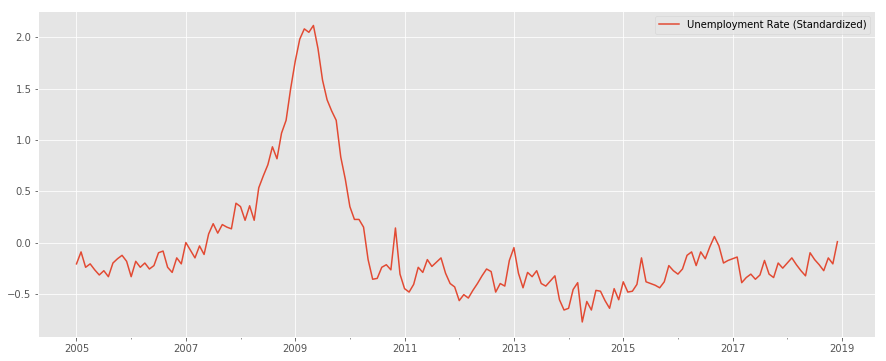

In [144]:
df_UE.plot(figsize=figsize)

***

### Unemployment ARIMA Model

**The function below represents an ARIMA model that cycles through a given range of p,d,q terms, which account for seasonality, trend and order.**

In [89]:
def arima_modeler(data,pdq_lower,pdq_upper,m):
    p = d = q = range(pdq_lower, pdq_upper)
    pdq = list(itertools.product(p, d, q))
    pdqs = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                print('except')
                continue
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    ans_df.loc[ans_df['aic'].idxmin()]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(data,
                                order=ans_df.loc[ans_df['aic'].idxmin()][0],
                                seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    output = ARIMA_MODEL.fit()
    print(output.summary().tables[1])
    return output

In [159]:
df_UE_model_output = arima_modeler(df_UE,0,3,12)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9695      0.015     64.950      0.000       0.940       0.999
sigma2         0.0196      0.002     10.109      0.000       0.016       0.023


### Test Results Section

**Diagnostic information related to the Unemployment Rate ARIMA Model**

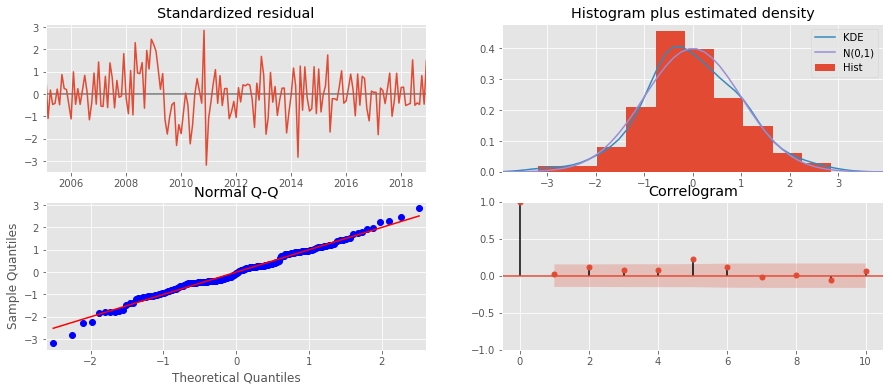

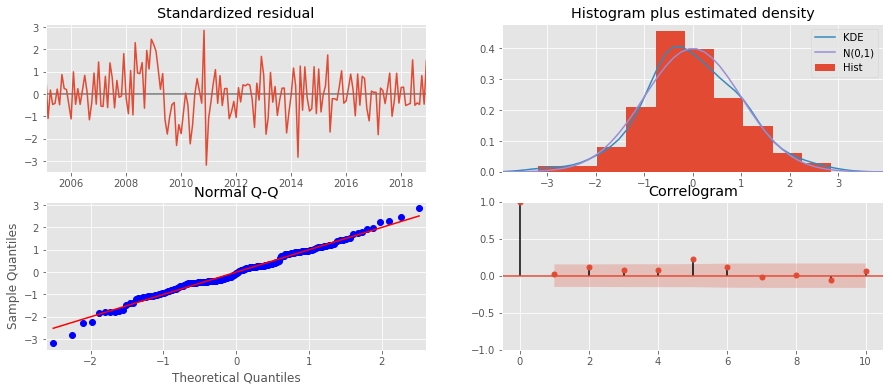

In [160]:
df_UE_model_output.plot_diagnostics(figsize=figsize)

### Forecast Table & Accuracy Results

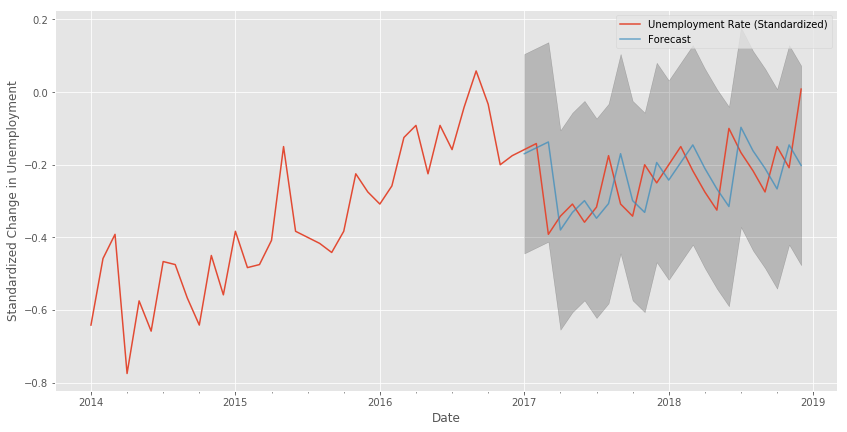

In [161]:
pred = df_UE_model_output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_UE_input['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Standardized Change in Unemployment')
plt.legend()
plt.show()

In [162]:
def mean_absolute_percentage_error(y_pred, y_true): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [163]:
y_forecasted = np.array(pred.predicted_mean)
y_truth = np.array(df_UE_input['2018-01-01':])
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 5)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 5)))
print('The Mean Average Percent Error is {}'.format(round(mean_absolute_percentage_error(y_forecasted,y_truth), 5)))

The Mean Squared Error is 0.01499
The Root Mean Squared Error is 0.12245
The Mean Average Percent Error is 2.83425


**OBSERVATION: Our inital model is generally off about 2.83% of the observed Unemployment Rate**

## SARIMAX Model

In [151]:
# Combine Dataframes
df_ue_js = df_UE.join(df_job)
# Rename Columns
df_ue_js.columns = ['unempl_rate (12mn RA)','prev_mon_job_search_rate']

In [153]:
# Parse Data for Review
training_range_end = '2017-12-31'
testing_range_start = '2018-01-01'
testing_range_end = '2018-12-31'

ts_train = df_ue_js.loc[:training_range_end,df_ue_js.columns[0]]
ts_test = df_ue_js.loc[testing_range_start:,df_ue_js.columns[0]].values
ex_train = df_ue_js.loc[:training_range_end,df_ue_js.columns[1]].values
ex_test = df_ue_js.loc[testing_range_start:,df_ue_js.columns[1]].values

data1 = ts_train.values
exog1 = ex_train

In [154]:
# PDQ Checker
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Find best order/seasonal_order params
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(data1,
                                            exog=exog1,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

            
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =282.5187624443979
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =249.2178803400861
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =298.2380763122134
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =277.99908485461367
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =249.7113504560859
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =248.575737989875
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =284.0488554973011
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =269.80471052799123
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =120.04720057870655
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =103.228711107537
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =159.0031108838009
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =143.39903030799627
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =105.2557637028647
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =104.43273217996366
ARIMA (0, 0, 1) x

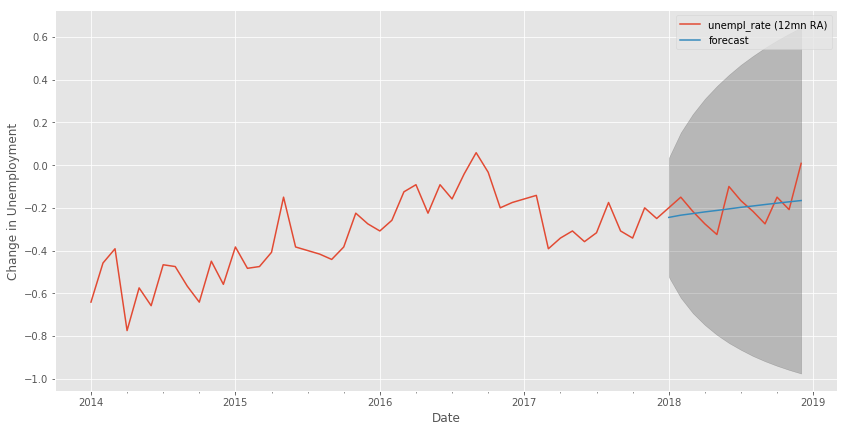

In [155]:
# fit model using order/seasonal_order with the lowest AIC scores from previous test
model = SARIMAX(data1, exog=exog1, order=ans_df.loc[ans_df['aic'].idxmin()][0], seasonal_order=ans_df.loc[ans_df['aic'].idxmin()][1])
model_fit = model.fit()

# make forecast
exog2 = ex_test.reshape(ex_test.shape[0],1)
yhat = model_fit.get_forecast(12,exog=exog2,dynamic=False)

# Graph forecast
yhat_df = pd.DataFrame(yhat.predicted_mean, index=pd.date_range(testing_range_start, periods=12, freq='MS'),columns=['forecast'])
yhat_df_ci = pd.DataFrame(yhat.conf_int(), index=pd.date_range(testing_range_start, periods=12, freq='MS'),columns=['ci_low','ci_high'])

fig, ax = plt.subplots()
ax = df_ue_js['unempl_rate (12mn RA)'].loc['2014':].plot(ax=ax)

yhat_df.plot(ax=ax, label='One-step ahead Forecast', figsize=(14, 7))
ax.fill_between(yhat_df_ci.index,
                yhat_df_ci.iloc[:, 0],
                yhat_df_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Change in Unemployment')
plt.legend()
plt.show()

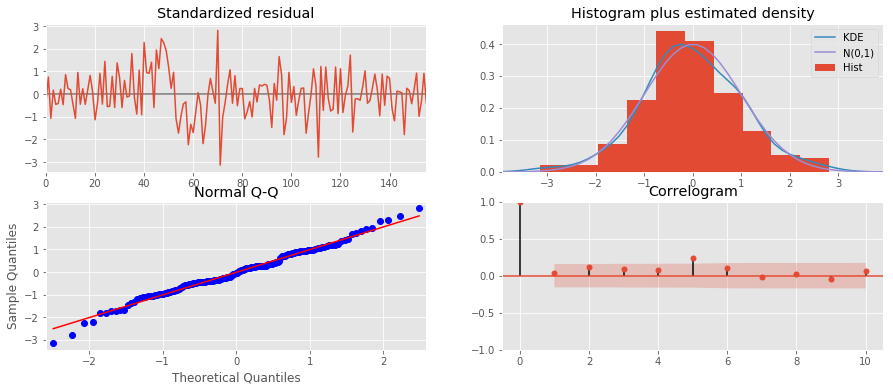

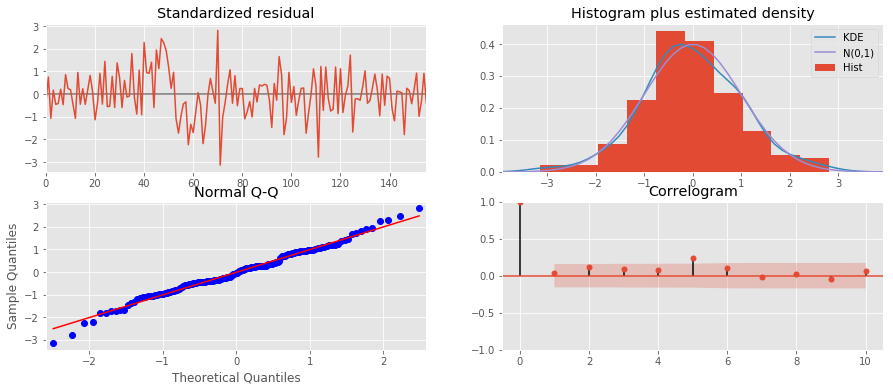

In [158]:
model_fit.plot_diagnostics(figsize=figsize)

In [157]:
# Determine MSE/RMSE
y_forecasted = yhat.predicted_mean
y_truth =  df_ue_js['unempl_rate (12mn RA)'].loc[testing_range_start:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 5)))
print('The Mean Average Percent Error is {}'.format(round(mean_absolute_percentage_error(y_forecasted,y_truth), 5)))

The Mean Squared Error of our forecasts is 0.00653
The Root Mean Squared Error of our forecasts is 0.0808
The Mean Average Percent Error is 2.0271


**OBSERVATION: Our job search model is generally off about 2.03% of the Unemployment Rate**

***

# Conclusion

- Our original time series ARIMA model yielded a 2.83% MAPE, and with the addition of 1 month lag job search data our results improved to 2.03%; an improvement of ~25%


- Through the use of additional Google Search data, we can better predict changes in unemployment

# Future Enhancements

- Additional exogenous keyword data:
    - Job Site Index
    - Career


- LSTM Models with exogenous data to drive more robust results


- More Data
    - Time as Google Trends gathers more data
    - Weekly Unemployment/Job Search Information


- Use Facebook Prophet to improve results